Iteration 0, Objective: -0.000000
Iteration 50, Objective: -0.000000
Iteration 100, Objective: -0.000000
Iteration 150, Objective: -0.000000
Iteration 200, Objective: -0.000000
Iteration 250, Objective: -0.000000
Iteration 300, Objective: -0.000000
Iteration 350, Objective: -0.000000
Iteration 400, Objective: -0.000000
Iteration 450, Objective: -0.000000
Iteration 500, Objective: -0.000000
Iteration 550, Objective: -0.000000
Iteration 600, Objective: -0.000000
Iteration 650, Objective: -0.000000
Iteration 700, Objective: -0.000000
Iteration 750, Objective: -0.000000
Iteration 800, Objective: -0.000000
Iteration 850, Objective: -0.000000
Iteration 900, Objective: -0.000000
Iteration 950, Objective: -0.000000


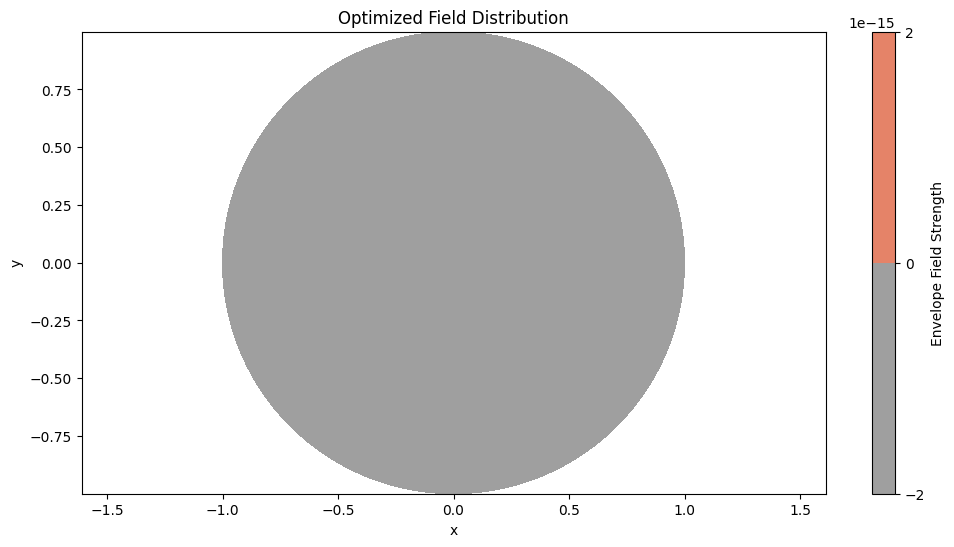

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
import optax
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# 初始化网格和常量
def initialize_grid(R=1.0, n_points=100):
    r = np.linspace(0, R, n_points)
    theta = np.linspace(0, 2 * np.pi, n_points)
    R_grid, Theta_grid = np.meshgrid(r, theta)
    cos_theta = np.cos(Theta_grid)
    sin_theta = np.sin(Theta_grid)
    return r, theta, R_grid, Theta_grid, cos_theta, sin_theta

# 计算单个电流对的电场
@jit
def calculate_individual_field(I, theta1, theta2, R_grid, Theta_grid, sigma=1.0, R=1.0, N_terms=50):
    r = jnp.array(R_grid)
    theta = jnp.array(Theta_grid)
    U = jnp.zeros_like(r)
    for n in range(1, N_terms + 1):
        An = I / (sigma * n * jnp.pi * R**n) * (jnp.cos(n * theta1) - jnp.cos(n * theta2))
        Bn = I / (sigma * n * jnp.pi * R**n) * (jnp.sin(n * theta1) - jnp.sin(n * theta2))
        U += r**n * (An * jnp.cos(n * theta) + Bn * jnp.sin(n * theta))
    
    dr = r[1, 0] - r[0, 0]
    dtheta = theta[0, 1] - theta[0, 0]
    
    dU_dr = jnp.zeros_like(U)
    dU_dr = dU_dr.at[:, 1:-1].set((U[:, 2:] - U[:, :-2]) / (2 * dr))
    dU_dr = dU_dr.at[:, 0].set((U[:, 1] - U[:, 0]) / dr)
    dU_dr = dU_dr.at[:, -1].set((U[:, -1] - U[:, -2]) / dr)
    
    dU_dtheta = jnp.zeros_like(U)
    dU_dtheta = dU_dtheta.at[1:-1, :].set((U[2:, :] - U[:-2, :]) / (2 * dtheta))
    dU_dtheta = dU_dtheta.at[0, :].set((U[1, :] - U[-1, :]) / (2 * dtheta))
    dU_dtheta = dU_dtheta.at[-1, :].set((U[0, :] - U[-2, :]) / (2 * dtheta))
    
    Er = -dU_dr
    Etheta = jnp.where(r > 0, -dU_dtheta / r, 0)
    return Er, Etheta

# 计算电场包络
@jit
def calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta, sigma=1.0, R=1.0):
    I1, theta1_1, theta1_2, I2, theta2_1, theta2_2 = currents
    E1r, E1theta = calculate_individual_field(I1, theta1_1, theta1_2, R_grid, Theta_grid, sigma, R)
    E2r, E2theta = calculate_individual_field(I2, theta2_1, theta2_2, R_grid, Theta_grid, sigma, R)
    
    E1x = E1r * cos_theta - E1theta * sin_theta
    E1y = E1r * sin_theta + E1theta * cos_theta
    E2x = E2r * cos_theta - E2theta * sin_theta
    E2y = E2r * sin_theta + E2theta * cos_theta
    
    E1_abs = jnp.sqrt(E1x**2 + E1y**2)
    E2_abs = jnp.sqrt(E2x**2 + E2y**2)
    
    dot = E1x * E2x + E1y * E2y
    E1_abs_safe = jnp.where(E1_abs == 0, 1e-12, E1_abs)
    E2_abs_safe = jnp.where(E2_abs == 0, 1e-12, E2_abs)
    cos_alpha = dot / (E1_abs_safe * E2_abs_safe)
    
    dEx = E1x - E2x
    dEy = E1y - E2y
    dE_abs = jnp.sqrt(dEx**2 + dEy**2) + 1e-12
    
    cross1 = E2x * dEy - E2y * dEx
    cross2 = E1x * (-dEy) - E1y * (-dEx)
    cross1_abs = jnp.abs(cross1)
    cross2_abs = jnp.abs(cross2)
    
    cond1 = (E1_abs > E2_abs) & (E2_abs < E1_abs * cos_alpha)
    cond2 = (E1_abs > E2_abs) & (E2_abs >= E1_abs * cos_alpha)
    cond3 = (E1_abs <= E2_abs) & (E1_abs < E2_abs * cos_alpha)
    cond4 = (E1_abs <= E2_abs) & (E1_abs >= E2_abs * cos_alpha)
    
    envelope = jnp.zeros_like(E1_abs)
    envelope = jnp.where(cond1, 2 * E2_abs, envelope)
    envelope = jnp.where(cond2, 2 * cross1_abs / dE_abs, envelope)
    envelope = jnp.where(cond3, 2 * E1_abs, envelope)
    envelope = jnp.where(cond4, 2 * cross2_abs / dE_abs, envelope)
    
    return envelope

# 创建目标区域掩模
def create_region_mask(R_grid, Theta_grid, region):
    if region["type"] == "circle":
        r_center, theta_center = region["center"]
        x_center = r_center * np.cos(theta_center)
        y_center = r_center * np.sin(theta_center)
        X = R_grid * np.cos(Theta_grid)
        Y = R_grid * np.sin(Theta_grid)
        distance = np.sqrt((X - x_center)**2 + (Y - y_center)**2)
        return distance <= region["radius"]
    elif region["type"] == "sector":
        start_angle, end_angle = region["angles"]
        angle_mask = (Theta_grid >= start_angle) & (Theta_grid <= end_angle)
        radius_mask = R_grid > 0
        return angle_mask & radius_mask
    else:
        raise ValueError("Unsupported region type. Use 'circle' or 'sector'.")

# 目标函数
@jit
def objective_function(currents, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta):
    envelope = calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta)
    E_hr = jnp.mean(jnp.where(hr_mask, envelope, 0.0)) * jnp.size(envelope) / jnp.sum(hr_mask)
    E_nh = jnp.mean(jnp.where(nh_mask, envelope, 0.0)) * jnp.size(envelope) / jnp.sum(nh_mask)
    E_nh_safe = jnp.where(E_nh < 1e-6, 1e-6, E_nh)
    return -E_hr / E_nh_safe

# 优化函数
def optimize(currents, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta, bounds, learning_rate=0.01, num_iterations=1000):
    params = jnp.array(currents)
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params)
    value_and_grad_fn = jit(value_and_grad(objective_function, argnums=0))
    
    @jit
    def step(params, opt_state):
        value, grads = value_and_grad_fn(params, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        for i, (lower, upper) in enumerate(bounds):
            params = params.at[i].set(jnp.clip(params[i], lower, upper))
        return params, opt_state, value
    
    values = []
    for i in range(num_iterations):
        params, opt_state, value = step(params, opt_state)
        values.append(float(value))
        if i % 50 == 0:
            print(f"Iteration {i}, Objective: {value:.6f}")
    
    return np.array(params), values

# 可视化结果
def visualize_results(currents, R_grid, Theta_grid, cos_theta, sin_theta, hr_mask, nh_mask):
    envelope = calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta)
    plt.figure(figsize=(12, 6))
    plt.contourf(R_grid * np.cos(Theta_grid), R_grid * np.sin(Theta_grid), envelope, levels=100, cmap="RdGy_r")
    plt.colorbar(label="Envelope Field Strength")
    plt.title("Optimized Field Distribution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

# 主函数
def main():
    R = 1.0
    n_points = 200
    r, theta, R_grid, Theta_grid, cos_theta, sin_theta = initialize_grid(R, n_points)
    target_region = {"type": "circle", "center": (0.5, np.pi / 4), "radius": 0.1}
    hr_mask = create_region_mask(R_grid, Theta_grid, target_region)
    nh_mask = ~hr_mask
    initial_currents = [1.0, np.pi / 3, 4 * np.pi / 3, 1.0, 5 * np.pi / 3, np.pi / 2]
    bounds = [(0.1, 2)] + [(0, 2 * np.pi)] * 2
    bounds *= len(initial_currents) // 3
    result, values = optimize(initial_currents, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta, bounds)
    visualize_results(result, R_grid, Theta_grid, cos_theta, sin_theta, hr_mask, nh_mask)

if __name__ == "__main__":
    main()

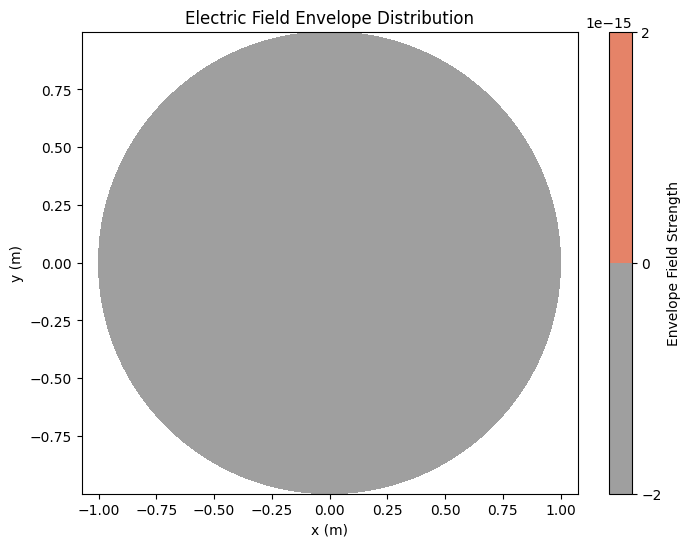

In [5]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
import optax
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# 初始化网格和常量
def initialize_grid(R=1.0, n_points=100):
    r = np.linspace(0, R, n_points)
    theta = np.linspace(0, 2 * np.pi, n_points)
    R_grid, Theta_grid = np.meshgrid(r, theta)
    cos_theta = np.cos(Theta_grid)
    sin_theta = np.sin(Theta_grid)
    return r, theta, R_grid, Theta_grid, cos_theta, sin_theta

# 计算单个电流对的电场
@jit
def calculate_individual_field(I, theta1, theta2, R_grid, Theta_grid, sigma=1.0, R=1.0, N_terms=50):
    r = jnp.array(R_grid)
    theta = jnp.array(Theta_grid)
    U = jnp.zeros_like(r)
    for n in range(1, N_terms + 1):
        An = I / (sigma * n * jnp.pi * R**n) * (jnp.cos(n * theta1) - jnp.cos(n * theta2))
        Bn = I / (sigma * n * jnp.pi * R**n) * (jnp.sin(n * theta1) - jnp.sin(n * theta2))
        U += r**n * (An * jnp.cos(n * theta) + Bn * jnp.sin(n * theta))
    
    dr = r[1, 0] - r[0, 0]
    dtheta = theta[0, 1] - theta[0, 0]
    
    dU_dr = jnp.zeros_like(U)
    dU_dr = dU_dr.at[:, 1:-1].set((U[:, 2:] - U[:, :-2]) / (2 * dr))
    dU_dr = dU_dr.at[:, 0].set((U[:, 1] - U[:, 0]) / dr)
    dU_dr = dU_dr.at[:, -1].set((U[:, -1] - U[:, -2]) / dr)
    
    dU_dtheta = jnp.zeros_like(U)
    dU_dtheta = dU_dtheta.at[1:-1, :].set((U[2:, :] - U[:-2, :]) / (2 * dtheta))
    dU_dtheta = dU_dtheta.at[0, :].set((U[1, :] - U[-1, :]) / (2 * dtheta))
    dU_dtheta = dU_dtheta.at[-1, :].set((U[0, :] - U[-2, :]) / (2 * dtheta))
    
    Er = -dU_dr
    Etheta = jnp.where(r > 0, -dU_dtheta / r, 0)
    return Er, Etheta

# 计算电场包络
@jit
def calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta, sigma=1.0, R=1.0):
    I1, theta1_1, theta1_2, I2, theta2_1, theta2_2 = currents
    E1r, E1theta = calculate_individual_field(I1, theta1_1, theta1_2, R_grid, Theta_grid, sigma, R)
    E2r, E2theta = calculate_individual_field(I2, theta2_1, theta2_2, R_grid, Theta_grid, sigma, R)
    
    E1x = E1r * cos_theta - E1theta * sin_theta
    E1y = E1r * sin_theta + E1theta * cos_theta
    E2x = E2r * cos_theta - E2theta * sin_theta
    E2y = E2r * sin_theta + E2theta * cos_theta
    
    E1_abs = jnp.sqrt(E1x**2 + E1y**2)
    E2_abs = jnp.sqrt(E2x**2 + E2y**2)
    
    dot = E1x * E2x + E1y * E2y
    E1_abs_safe = jnp.where(E1_abs == 0, 1e-12, E1_abs)
    E2_abs_safe = jnp.where(E2_abs == 0, 1e-12, E2_abs)
    cos_alpha = dot / (E1_abs_safe * E2_abs_safe)
    
    dEx = E1x - E2x
    dEy = E1y - E2y
    dE_abs = jnp.sqrt(dEx**2 + dEy**2) + 1e-12
    
    cross1 = E2x * dEy - E2y * dEx
    cross2 = E1x * (-dEy) - E1y * (-dEx)
    cross1_abs = jnp.abs(cross1)
    cross2_abs = jnp.abs(cross2)
    
    cond1 = (E1_abs > E2_abs) & (E2_abs < E1_abs * cos_alpha)
    cond2 = (E1_abs > E2_abs) & (E2_abs >= E1_abs * cos_alpha)
    cond3 = (E1_abs <= E2_abs) & (E1_abs < E2_abs * cos_alpha)
    cond4 = (E1_abs <= E2_abs) & (E1_abs >= E2_abs * cos_alpha)
    
    envelope = jnp.zeros_like(E1_abs)
    envelope = jnp.where(cond1, 2 * E2_abs, envelope)
    envelope = jnp.where(cond2, 2 * cross1_abs / dE_abs, envelope)
    envelope = jnp.where(cond3, 2 * E1_abs, envelope)
    envelope = jnp.where(cond4, 2 * cross2_abs / dE_abs, envelope)
    
    return envelope

# 创建目标区域掩模
def create_region_mask(R_grid, Theta_grid, region):
    if region["type"] == "circle":
        r_center, theta_center = region["center"]
        x_center = r_center * np.cos(theta_center)
        y_center = r_center * np.sin(theta_center)
        X = R_grid * np.cos(Theta_grid)
        Y = R_grid * np.sin(Theta_grid)
        distance = np.sqrt((X - x_center)**2 + (Y - y_center)**2)
        return distance <= region["radius"]
    elif region["type"] == "sector":
        start_angle, end_angle = region["angles"]
        angle_mask = (Theta_grid >= start_angle) & (Theta_grid <= end_angle)
        radius_mask = R_grid > 0
        return angle_mask & radius_mask
    else:
        raise ValueError("Unsupported region type. Use 'circle' or 'sector'.")

# 目标函数
@jit
def objective_function(currents, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta):
    envelope = calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta)
    E_hr = jnp.mean(jnp.where(hr_mask, envelope, 0.0)) * jnp.size(envelope) / jnp.sum(hr_mask)
    E_nh = jnp.mean(jnp.where(nh_mask, envelope, 0.0)) * jnp.size(envelope) / jnp.sum(nh_mask)
    E_nh_safe = jnp.where(E_nh < 1e-6, 1e-6, E_nh)
    return -E_hr / E_nh_safe

# 优化函数
def optimize(currents, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta, bounds, learning_rate=0.01, num_iterations=1000):
    params = jnp.array(currents)
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params)
    value_and_grad_fn = jit(value_and_grad(objective_function, argnums=0))
    
    @jit
    def step(params, opt_state):
        value, grads = value_and_grad_fn(params, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        for i, (lower, upper) in enumerate(bounds):
            params = params.at[i].set(jnp.clip(params[i], lower, upper))
        return params, opt_state, value
    
    values = []
    for i in range(num_iterations):
        params, opt_state, value = step(params, opt_state)
        values.append(float(value))
        if i % 50 == 0:
            print(f"Iteration {i}, Objective: {value:.6f}")
    
    return np.array(params), values

# 可视化结果
def visualize_results(currents, R_grid, Theta_grid, cos_theta, sin_theta, hr_mask, nh_mask):
    envelope = calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta)
    plt.figure(figsize=(12, 6))
    plt.contourf(R_grid * np.cos(Theta_grid), R_grid * np.sin(Theta_grid), envelope, levels=100, cmap="RdGy_r")
    plt.colorbar(label="Envelope Field Strength")
    plt.title("Optimized Field Distribution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

# 主函数
def main():
    R = 1.0
    n_points = 200
    r, theta, R_grid, Theta_grid, cos_theta, sin_theta = initialize_grid(R, n_points)
    target_region = {"type": "circle", "center": (0.5, np.pi / 4), "radius": 0.1}
    hr_mask = create_region_mask(R_grid, Theta_grid, target_region)
    nh_mask = ~hr_mask
    initial_currents = [1.0, np.pi / 3, 4 * np.pi / 3, 1.0, 5 * np.pi / 3, np.pi / 2]
    bounds = [(0.1, 2)] + [(0, 2 * np.pi)] * 2
    bounds *= len(initial_currents) // 3
    result, values = optimize(initial_currents, hr_mask, nh_mask, R_grid, Theta_grid, cos_theta, sin_theta, bounds)
    visualize_results(result, R_grid, Theta_grid, cos_theta, sin_theta, hr_mask, nh_mask)

def visualize_envelope_with_currents():
    # 初始化网格
    R = 1.0
    n_points = 200
    r, theta, R_grid, Theta_grid, cos_theta, sin_theta = initialize_grid(R, n_points)

    # 定义两对电流
    currents = [
        1.0, 2 * np.pi / 3, np.pi,  # 第一对电流
        1.0, np.pi / 3, 0           # 第二对电流
    ]

    # 计算包络电场
    envelope = calculate_envelope(currents, R_grid, Theta_grid, cos_theta, sin_theta)

    # 可视化包络电场
    plt.figure(figsize=(8, 6))
    plt.contourf(R_grid * np.cos(Theta_grid), R_grid * np.sin(Theta_grid), envelope, levels=100, cmap="RdGy_r")
    plt.colorbar(label="Envelope Field Strength")
    plt.title("Electric Field Envelope Distribution")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.axis("equal")
    plt.show()

if __name__ == "__main__":
    # 调用函数
    visualize_envelope_with_currents()